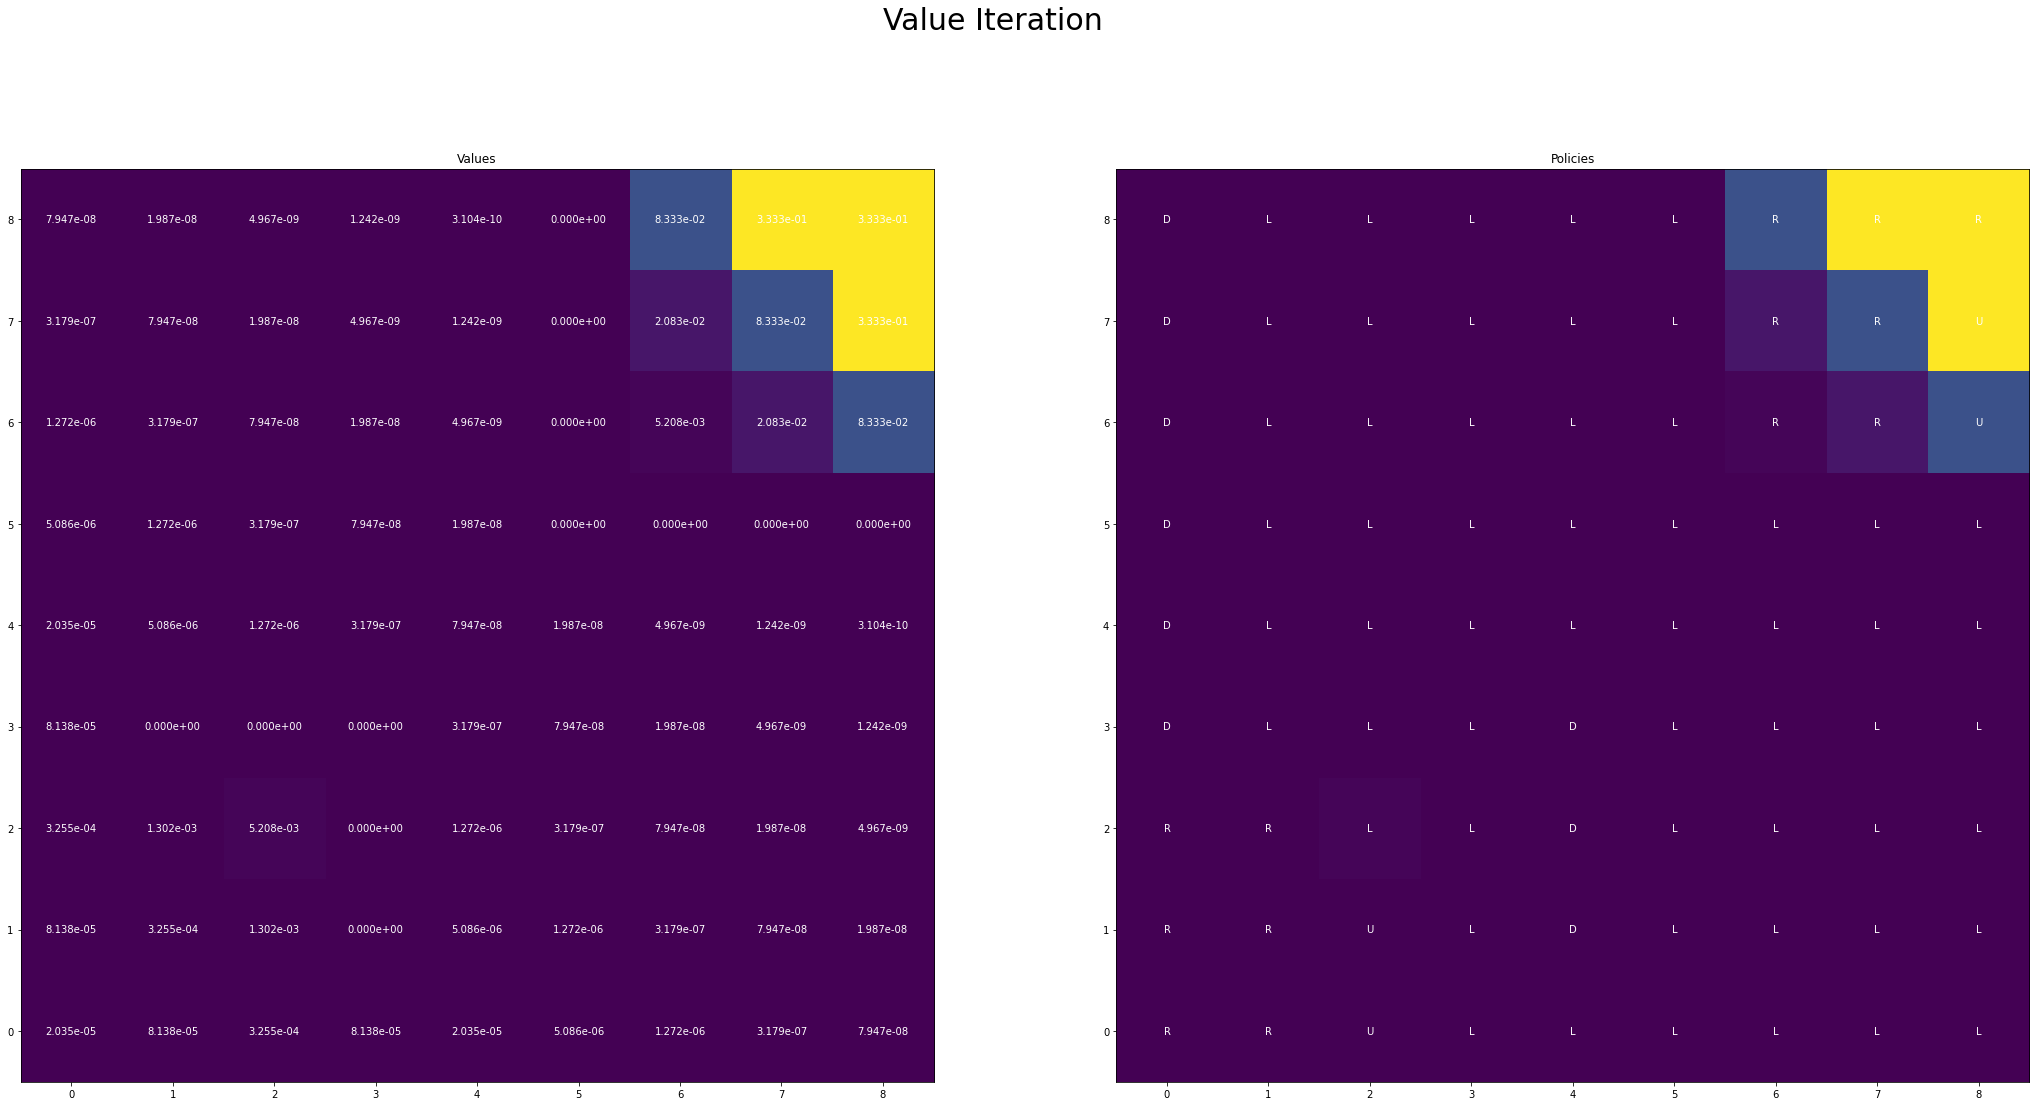

Policy Actions:
U = Up
D = Down
L = Left
R = Right
NOTE:
Where ever the Value of a State is 0, it is the obstacle/wall where the robot agent can't travel


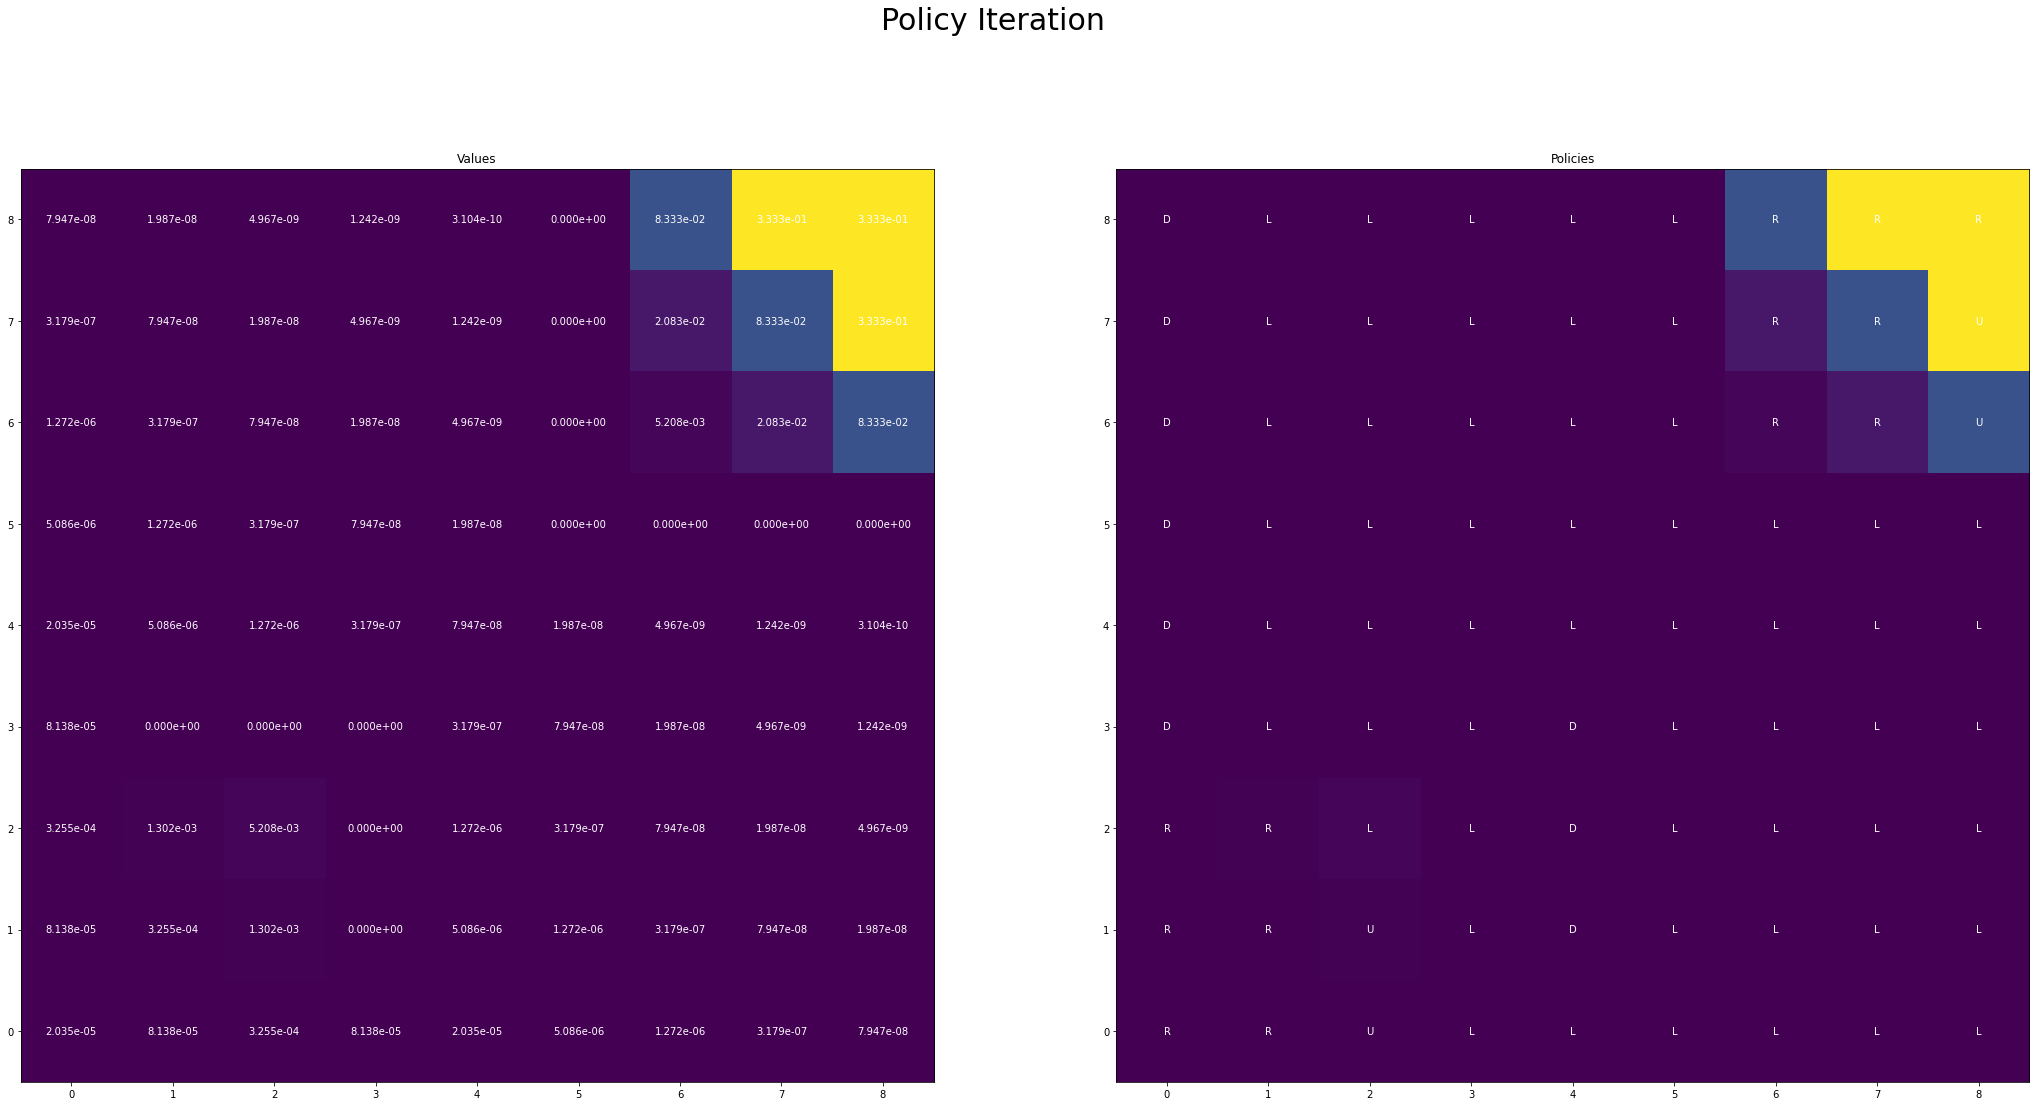

Policy Actions:
U = Up
D = Down
L = Left
R = Right
NOTE:
Where ever the Value of a State is 0, it is the obstacle/wall where the robot agent can't travel


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# Coordinate class
class Coordinate:
    def __init__(self, x: int, y: int):
        self.X = x
        self.Y = y
    
    def __eq__(self, other):
        if isinstance(other, Coordinate):
            return self.X == other.X and self.Y == other.Y
        return False
    
    def __hash__(self):
        return hash((self.X, self.Y))

# State class
class State:
    def __init__(self, name: str, reward: float):
        self.Name = name
        self.Reward = reward

# Action class
class Action:
    def __init__(self, name: str):
        self.Name = name

# Transition class
class Transition:
    def __init__(self, next_state: State, probability: float):
        self.NextState = next_state
        self.Probability = probability

# Environment class
class Environment:
    def __init__(self, n: int, obstacles: List[Coordinate], portal_in: Coordinate, portal_out: Coordinate, goal: Coordinate):
        self.n = n
        self.Walkable: Dict[Coordinate, State] = {}
        self.Obstacles: Dict[Coordinate, State] = {}
        self.PortalIn: Dict[Coordinate, State] = {}
        self.PortalOut: Dict[Coordinate, State] = {}
        self.Goal: Dict[Coordinate, State] = {}
        self.States: List[State] = []
        self.Actions: List[Action] = []

        # Initialize states
        for obstacle in obstacles:
            obstacle_state = State(f"obstacle_{obstacle.X}_{obstacle.Y}", 0)
            self.Obstacles[obstacle] = obstacle_state
            self.States.append(obstacle_state)

        portal_in_state = State(f"portalIn_{portal_in.X}_{portal_in.Y}", 0)
        self.PortalIn[portal_in] = portal_in_state
        self.States.append(portal_in_state)

        portal_out_state = State(f"portalOut_{portal_out.X}_{portal_out.Y}", 0)
        self.PortalOut[portal_out] = portal_out_state
        self.States.append(portal_out_state)

        goal_state = State(f"goal_{goal.X}_{goal.Y}", 1)
        self.Goal[goal] = goal_state
        self.States.append(goal_state)

        for i in range(n):
            for j in range(n):
                current = Coordinate(i, j)
                if (current not in obstacles and
                    current != portal_in and
                    current != portal_out and
                    current != goal):
                    walkable_state = State(f"walkable_{current.X}_{current.Y}", 0)
                    self.Walkable[current] = walkable_state
                    self.States.append(walkable_state)

        # Initialize actions
        self.Actions = [Action("Left"), Action("Right"), Action("Up"), Action("Down")]

# MDP class (simplified version, actual implementation would be more complex)
class MDP:
    def __init__(self, states: List[State], actions: List[Action]):
        self.States = states
        self.Actions = actions
        self.StateActions: Dict[Tuple[State, Action], List[Transition]] = {}

    def AddStateAction(self, state: State, action: Action, transitions: List[Transition]):
        self.StateActions[(state, action)] = transitions

    def PolicyIteration(self, gamma: float, epsilon: float):
        # Implement policy iteration algorithm
        v = {state: 0 for state in self.States}
        policy = {state: np.random.choice(self.Actions) for state in self.States}
        
        # Simplified policy iteration
        while True:
            # Policy evaluation
            while True:
                delta = 0
                for state in self.States:
                    v_old = v[state]
                    action = policy[state]
                    v[state] = sum(trans.Probability * (trans.NextState.Reward + gamma * v[trans.NextState]) 
                                   for trans in self.StateActions.get((state, action), []))
                    delta = max(delta, abs(v_old - v[state]))
                if delta < epsilon:
                    break
            
            # Policy improvement
            policy_stable = True
            for state in self.States:
                old_action = policy[state]
                policy[state] = max(self.Actions, 
                                    key=lambda a: sum(trans.Probability * (trans.NextState.Reward + gamma * v[trans.NextState]) 
                                                      for trans in self.StateActions.get((state, a), [])))
                if old_action != policy[state]:
                    policy_stable = False
            
            if policy_stable:
                break

        return v, policy

    def ValueIteration(self, gamma: float, epsilon: float):
        # Implement value iteration algorithm
        v = {state: 0 for state in self.States}
        
        while True:
            delta = 0
            for state in self.States:
                v_old = v[state]
                v[state] = max(sum(trans.Probability * (trans.NextState.Reward + gamma * v[trans.NextState]) 
                                   for trans in self.StateActions.get((state, action), []))
                               for action in self.Actions)
                delta = max(delta, abs(v_old - v[state]))
            if delta < epsilon:
                break

        # Extract policy
        policy = {}
        for state in self.States:
            policy[state] = max(self.Actions, 
                                key=lambda a: sum(trans.Probability * (trans.NextState.Reward + gamma * v[trans.NextState]) 
                                                  for trans in self.StateActions.get((state, a), [])))

        return v, policy

# Main execution
def main():
    n = 9
    gamma = 1
    epsilon = 1e-15

    obstacles = [
        Coordinate(3, 1), Coordinate(3, 2), Coordinate(3, 3), Coordinate(2, 3), Coordinate(1, 3),
        Coordinate(5, 5), Coordinate(5, 6), Coordinate(5, 7), Coordinate(5, 8),
        Coordinate(6, 5), Coordinate(7, 5), Coordinate(8, 5)
    ]

    portal_in = Coordinate(2, 2)
    portal_out = Coordinate(6, 6)
    goal = Coordinate(8, 8)

    env = Environment(n, obstacles, portal_in, portal_out, goal)
    mdp = MDP(env.States, env.Actions)

    # Add state actions (simplified version)
    for i in range(n):
        for j in range(n):
            current = Coordinate(i, j)
            if current not in env.Obstacles and current not in env.PortalIn:
                for action in env.Actions:
                    transitions = create_transition_list(env, current, action)
                    if current in env.Walkable:
                        mdp.AddStateAction(env.Walkable[current], action, transitions)
                    elif current in env.PortalOut:
                        mdp.AddStateAction(env.PortalOut[current], action, transitions)
                    elif current in env.Goal:
                        mdp.AddStateAction(env.Goal[current], action, transitions)

    v_value_iter, p_value_iter = mdp.ValueIteration(gamma, epsilon)
    v_policy_iter, p_policy_iter = mdp.PolicyIteration(gamma, epsilon)

    # Adjust portal in values
    v_value_iter[env.PortalIn[portal_in]] = v_value_iter[env.PortalOut[portal_out]]
    v_policy_iter[env.PortalIn[portal_in]] = v_policy_iter[env.PortalOut[portal_out]]

    # Plotting
    plot_valueIteration(env.States, v_value_iter, p_value_iter)
    plot_policyIteration(env.States, v_policy_iter, p_policy_iter)

def create_transition_list(env: Environment, current: Coordinate, action: Action) -> List[Transition]:
    transitions = []
    next_tile = get_next_tile(current, action)

    if is_obstacle_or_boundary(env, next_tile):
        next_state = get_state_for_coordinate(env, current)
        transitions.append(Transition(next_state, 0.25))
    elif next_tile in env.PortalIn:
        portal_out = list(env.PortalOut.keys())[0]
        next_state = env.PortalOut[portal_out]
        transitions.append(Transition(next_state, 0.25))
    elif next_tile in env.Walkable:
        next_state = env.Walkable[next_tile]
        transitions.append(Transition(next_state, 0.25))
    elif next_tile in env.Goal:
        next_state = env.Goal[next_tile]
        transitions.append(Transition(next_state, 0.25))

    return transitions

def get_next_tile(current: Coordinate, action: Action) -> Coordinate:
    if action.Name == "Left":
        return Coordinate(current.X - 1, current.Y)
    elif action.Name == "Right":
        return Coordinate(current.X + 1, current.Y)
    elif action.Name == "Up":
        return Coordinate(current.X, current.Y + 1)
    elif action.Name == "Down":
        return Coordinate(current.X, current.Y - 1)

def is_obstacle_or_boundary(env: Environment, tile: Coordinate) -> bool:
    return (tile.X < 0 or tile.Y < 0 or tile.X >= env.n or tile.Y >= env.n or tile in env.Obstacles)

def get_state_for_coordinate(env: Environment, coord: Coordinate) -> State:
    if coord in env.Goal:
        return env.Goal[coord]
    elif coord in env.Walkable:
        return env.Walkable[coord]
    elif coord in env.PortalOut:
        return env.PortalOut[coord]
    else:
        raise ValueError(f"No state found for coordinate {coord}")

def plot_valueIteration(states, values, policies):
    plot_grid(states, values, policies, "Value Iteration")

def plot_policyIteration(states, values, policies):
    plot_grid(states, values, policies, "Policy Iteration")

def plot_grid(states, values, policies, title):
    x_coords, y_coords, v, p = [], [], [], []
    for state in states:
        parts = state.Name.split('_')
        x_coords.append(int(parts[1]))
        y_coords.append(int(parts[2]))
        v.append(values[state])
        p.append(policies[state].Name)

    grid_size_x = grid_size_y = 9
    grid_v = np.full((grid_size_y, grid_size_x), np.nan)
    grid_p = np.full((grid_size_y, grid_size_x), "", dtype=str)

    for x, y, val, policy in zip(x_coords, y_coords, v, p):
        grid_v[y, x] = val
        grid_p[y, x] = policy

    fig, axes = plt.subplots(1, 2, figsize=(36, 18))
    fig.suptitle(title, fontsize=30)

    axes[0].imshow(grid_v, origin='lower')
    axes[0].set_title('Values')
    for y in range(grid_size_y):
        for x in range(grid_size_x):
            if not np.isnan(grid_v[y, x]):
                axes[0].text(x, y, f'{grid_v[y, x]:.3e}', ha='center', va='center', color='white')

    axes[1].imshow(grid_v, origin='lower')
    axes[1].set_title("Policies")
    for y in range(grid_size_y):
        for x in range(grid_size_x):
            if grid_p[y, x]:
                axes[1].text(x, y, grid_p[y, x], ha='center', va='center', color='white')

    plt.show()
    print("Policy Actions:\nU = Up\nD = Down\nL = Left\nR = Right")
    print("NOTE:\nWhere ever the Value of a State is 0, it is the obstacle/wall where the robot agent can't travel")
if __name__ == "__main__":
    main()